Energy Consumption Prediction for Energy4Climate
=======================

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')



In [121]:
##This is where we define our forecast window, that is, the number of points that the model will predict in the future 
sequence_length = int(60/15*6)

## 1. Data Processing

#### 1.1 Data Loading
We will load the data that is in .csv format. We choose the columns that interest us and organize the data by date. 

In [122]:
df = pd.read_csv('../Data/DrahiX_Data.csv', usecols=[0,1,2,3,4,5,6,7,8,9,10,11,21,22,23,24], index_col=0, parse_dates=True)

#### 1.2 Data Resampling

We will reorganize the loaded data in 15 minute intervals and add new features related to date and time. 

In [123]:
df = df.resample('15Min').mean()
df = df.fillna(method='ffill')

Consumption = df['T1']+df['T2']+df['T3']+df['T4']
df.index = df.index + pd.Timedelta(minutes=15*sequence_length)

#Adding new features so that we can use the date and time in the model
df['day of the week'] = df.index.dayofweek
df['day of the year'] = df.index.dayofyear
df['hour of the day'] = df.index.hour
df['minute of the hour'] = df.index.minute
df["Consumption"] = Consumption

df = df.iloc[:-sequence_length]
df = df.drop(columns = ['TGBT','T1','T2','T3','T4','T5','T6','T7'])

#### 1.3 Selection of Features and Targets 

After loading and reorganizing the data we can select the features that are useful for creating the model and the variables that will be predicted. To choose the best features to enter in the model we will calculate a correlation matrix between all dataset components and choose those that most affect consumption. 

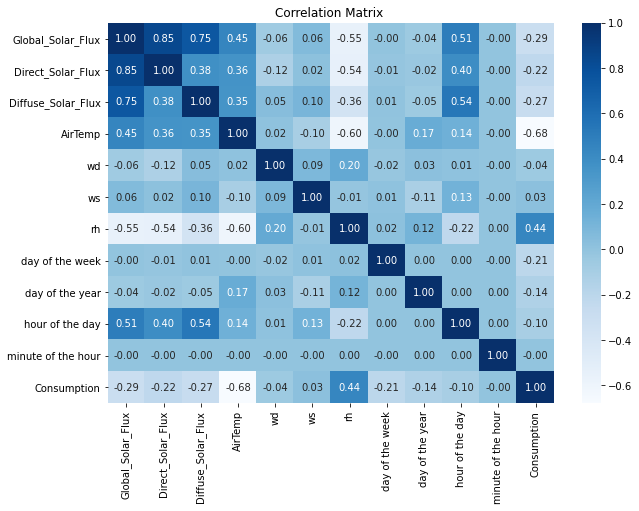

In [124]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlation Matrix ')
plt.show()

In [125]:
features = ['day of the week','day of the year','hour of the day','AirTemp', 'rh']
labels   = ["Consumption",]
inputs   = features + labels
df = df[inputs]


num_features = len(features)
num_labels = len(labels)
num_inputs = num_features + num_labels



#### 1.4 Data normalization 

Now we are going to normalize the data we have in the range between -1 and 1. These data are normalized independently between them and this facilitates the prediction by the model. 

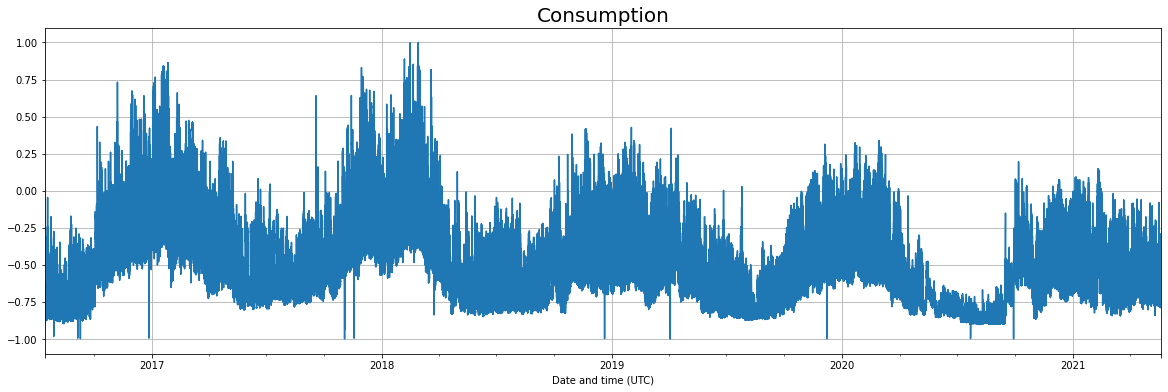

In [126]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

for i in range(len(labels)):
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)
    df_scaled[labels[i]].plot(ax=ax)
    plt.title(labels[i], fontsize=20)
    plt.grid(True)
    plt.show()

#### 1.5 Data Division for Testing and Learning 

We now split our dataset into two distinct subsets. A set that will be used for training the neural network and a test set that will be used to validate and evaluate the performance of the model. 

In [127]:
def split_data(data, test_size=0.25):
    """
    splits data to training and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    df_train, df_test = data.iloc[:ntest], data.iloc[ntest:]
    return df_train, df_test


In [128]:
df_train, df_test = split_data(df_scaled, test_size=0.33)

x_train_scaled = np.asarray(df_train[features])
x_test_scaled = np.asarray(df_test[features])
y_test_scaled = np.asarray(df_test[labels])
y_train_scaled = np.asarray(df_train[labels])

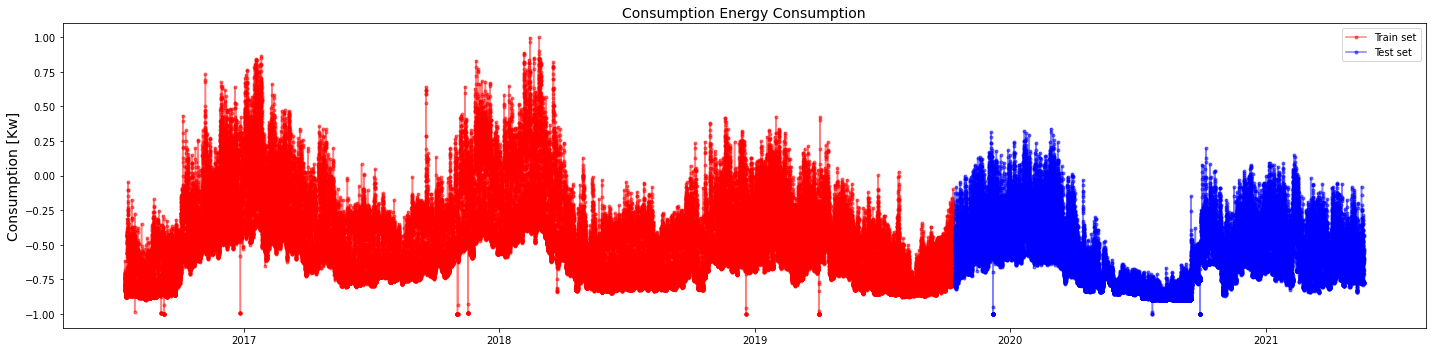

Total Data Size  :169897
Test Data Size  :56066
Train Data Size :113831


In [129]:
    
num_test = len(df_test) 
num_train = len(df_train)
num_total = len(df)


split_index = num_train
X_train_values  = df[:split_index] # get the datetime values of X_train
X_test_values = df[split_index:]

for i in range(len(labels)):
    plt.figure(figsize=(20,5))
    plt.plot(X_train_values.index, np.stack(y_train_scaled,axis=-1)[i], '.-', color='red', label='Train set', alpha=0.5)
    plt.plot(X_test_values.index, np.stack(y_test_scaled,axis=-1)[i], '.-', color='blue', label='Test set', alpha=0.5)
    plt.legend()
    plt.ylabel('Consumption [Kw]', fontsize=14)
    plt.title(labels[i]+' Energy Consumption', fontsize=14)
    plt.tight_layout()
    plt.show()


print(f'Total Data Size  :{len(df)}\n'+
f'Test Data Size  :{len(df_test)}\n'+
f'Train Data Size :{len(df_train)}')

#### 1.6 Batch Creation

In [130]:
def batch_generator(batch_size, sequence_length, num_features, num_labels, num_test, x, y):
    """
    Generator function for creating random batches of training-data.
    """

    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_labels)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
   
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            if num_test<sequence_length:
                print("there will be a problem test too short", num_test)
            idx = np.random.randint(num_test - 2*sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x[idx:idx+sequence_length]
            y_batch[i] = y[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)


X Batch Shape :  (500, 24, 5)
Y Batch Shape :  (500, 24, 5)


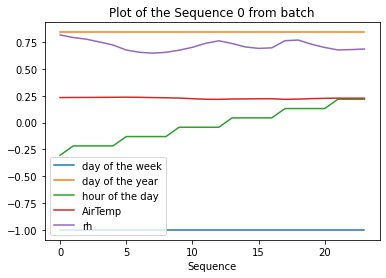

In [131]:
batch_size = 500

generator     = batch_generator(batch_size, sequence_length, num_features, 
                                num_labels, num_train, x_train_scaled, y_train_scaled)
testgenerator = batch_generator(batch_size, sequence_length, num_features, 
                                num_labels, num_test,  x_test_scaled,  y_test_scaled)

x_batch, y_batch = next(generator)

print(f'X Batch Shape :  {x_batch.shape}')
print(f'Y Batch Shape :  {x_batch.shape}')

seq = x_batch[0, :, :]
plt.plot(seq)
plt.xlabel('Sequence')
plt.legend(features)
plt.title(f'Plot of the Sequence 0 from batch')
plt.show()

## 2. LSTM Model

In [132]:
from tensorflow.keras.utils import Progbar


num_neurons = 150  # was 10
learning_rate = 0.001
num_layers = 5
num_iter = 2000
keep_prob = 0.2

next(testgenerator)

graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, [None, sequence_length, num_features], name='x')
    y = tf.placeholder(tf.float32, [None, sequence_length, num_labels], name="y") 
    
    def get_a_cell(lstm_size, keep_prob):
            lstm = tf.nn.rnn_cell.LSTMCell(lstm_size)
            drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
            return drop
    
with graph.as_default():
    with tf.name_scope('lstm'):
        cell = tf.nn.rnn_cell.MultiRNNCell([get_a_cell(num_neurons, 1-keep_prob) for _ in range(num_layers)])


    outputs, current_state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

    # from another program 
    stacked_rnn_output = tf.reshape(outputs, [-1, num_neurons])           #change the form into a tensor
    stacked_outputs = tf.layers.dense(stacked_rnn_output, num_labels) 
    outputs = tf.reshape(stacked_outputs, [-1, sequence_length, num_labels],name="op_to_restore")          #shape of results

    loss = tf.losses.mean_squared_error(y, outputs)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
     
    train = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    
    with tf.Session(graph=graph) as sess:
        sess.run(init)
        histogram_summary = tf.summary.scalar('MSE', loss)
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter('./graphs', sess.graph)
        progbar = Progbar(num_iter)
        
        #saver = tf.train.import_meta_graph('Model'+str(24)+'/my_test_model-1000.meta')
        #saver.restore(sess,tf.train.latest_checkpoint('./Model'+str(24)+'/'))
        
        for iter in range(num_iter):
            x_batch, y_batch = next(generator)
            _current_state, l = sess.run([current_state, train], feed_dict={x: x_batch, y: y_batch})
            histogram_summary = tf.summary.histogram('My_histogram_summary', loss)
            res_sum = sess.run(merged, feed_dict={x: x_batch, y: y_batch})   
            mse = loss.eval(feed_dict={x: x_batch, y: y_batch})
           # writer.add_summary(res_sum, iter)
            progbar.update(iter, values=[('MSE', mse)])
            
            
        saver.save(sess, 'Model'+str(sequence_length)+'X/my_test_model',global_step=1000)
            
        x_btest, ybtest = next(testgenerator)
        y_pred = sess.run(outputs, feed_dict={x: x_btest})

        ind = (len(x_test_scaled)//(sequence_length))*sequence_length
        x_test_tensor = x_test_scaled[0:ind].reshape([-1, sequence_length, num_features])
        y_model = sess.run(outputs, feed_dict={x: x_test_tensor})  


    

1999/2000 [============================>.] - ETA: 0s - MSE: 0.0205

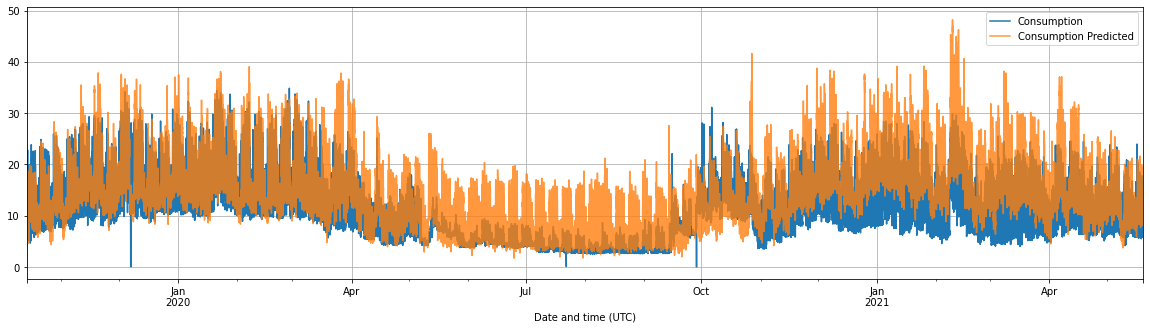

In [133]:
y_test = y_model.reshape(-1, num_labels)

scaler.fit(df[labels])
DF = pd.DataFrame(scaler.inverse_transform(y_test), index=df_test.iloc[0:ind].index, columns=labels)

for i in range(len(labels)):
    fig = plt.figure(figsize=(20, 5))
    df[labels[i]].iloc[num_train:].plot()
    DF[labels[i]].plot( label=labels[i]+' Predicted',alpha=0.8)
    plt.legend()
    plt.grid()
    plt.show()


In [134]:
from math import sqrt
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1))
print('MSE : %.3f' % mse)
rmse = sqrt(mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1)))
print('RMSE : %.3f' % rmse)

MSE : 0.051
RMSE : 0.227
